# Timor-Leste Map

## Map making with Python!

In [15]:
# Import our libraries
import altair
import requests
import pandas
import geopandas
import json

## Altair Settings (Only for Juptyer Notebook)

In [16]:
altair.renderers.enable('notebook')
altair.themes.enable('opaque')

ThemeRegistry.enable('opaque')

## Read geojson from file

In [17]:
def read_json_file(path):
    '''Reads JSON file and Returns JSON'''
    with open(path, 'r') as json_file:
        return json.load(json_file)

# Read geojson from file
geojson = read_json_file('maps_data/districts.geojson')

# Load our GeoJSON into a GeoPandas GeoDataFrame
geodataframe = geopandas.GeoDataFrame.from_features((geojson))
geodataframe.head()

,DISTR,DISTRICT,NEWDISCODE,geometry
0,DISTRITO DE AILEU,AILEU,2,POLYGON ((125.7706527709961 -8.587400436401367...
1,DISTRITO DE AINARO,AINARO,1,POLYGON ((125.6111907958984 -8.938739776611328...
2,DISTRITO DE BAUCAU,BAUCAU,3,POLYGON ((126.1930770874023 -8.573740005493164...
3,DISTRITO DE BOBONARO,BOBONARO,4,POLYGON ((125.0385131835938 -9.033220291137695...
4,DISTRITO DE COVALIMA,COVALIMA,5,POLYGON ((125.0958404541016 -9.201809883117676...


## make a pandas dataframe from a CSV file

In [18]:
language_frame = pandas.read_csv('maps_data/distritu_nia_luan.csv')
language_frame.head()

,NEWDISCODE,DISTRICT,LIAN,LIAFUAN,AREA_LUAN
0,2,AILEU,Mambae (Aileu),Hato,729
1,1,AINARO,Mambae (Ainaro),Hato,797
2,3,BAUCAU,NaN,NaN,1494
3,4,BOBONARO,Kemak (Marobo),Hatu / Atsu,1368
4,5,COVALIMA,English (Covalima),Stone / Rock,1226


### Then we will merge that language_frame with our geodataframe based on the location (DISTRICT)

In [19]:
merge_dataframe = pandas.merge(geodataframe, language_frame, on='DISTRICT', how='inner')
merge_dataframe.head()

,DISTR,DISTRICT,NEWDISCODE_x,geometry,NEWDISCODE_y,LIAN,LIAFUAN,AREA_LUAN
0,DISTRITO DE AILEU,AILEU,2,POLYGON ((125.7706527709961 -8.587400436401367...,2,Mambae (Aileu),Hato,729
1,DISTRITO DE AINARO,AINARO,1,POLYGON ((125.6111907958984 -8.938739776611328...,1,Mambae (Ainaro),Hato,797
2,DISTRITO DE BAUCAU,BAUCAU,3,POLYGON ((126.1930770874023 -8.573740005493164...,3,NaN,NaN,1494
3,DISTRITO DE BOBONARO,BOBONARO,4,POLYGON ((125.0385131835938 -9.033220291137695...,4,Kemak (Marobo),Hatu / Atsu,1368
4,DISTRITO DE COVALIMA,COVALIMA,5,POLYGON ((125.0958404541016 -9.201809883117676...,5,English (Covalima),Stone / Rock,1226


## add the center lat and lon for each shape

In [20]:
merge_dataframe['centroid_lon'] = merge_dataframe['geometry'].centroid.x
merge_dataframe['centroid_lat'] = merge_dataframe['geometry'].centroid.y
merge_dataframe.head()

,DISTR,DISTRICT,NEWDISCODE_x,geometry,NEWDISCODE_y,LIAN,LIAFUAN,AREA_LUAN,centroid_lon,centroid_lat
0,DISTRITO DE AILEU,AILEU,2,POLYGON ((125.7706527709961 -8.587400436401367...,2,Mambae (Aileu),Hato,729,125.636182,-8.701687
1,DISTRITO DE AINARO,AINARO,1,POLYGON ((125.6111907958984 -8.938739776611328...,1,Mambae (Ainaro),Hato,797,125.573768,-9.000691
2,DISTRITO DE BAUCAU,BAUCAU,3,POLYGON ((126.1930770874023 -8.573740005493164...,3,NaN,NaN,1494,126.469606,-8.565277
3,DISTRITO DE BOBONARO,BOBONARO,4,POLYGON ((125.0385131835938 -9.033220291137695...,4,Kemak (Marobo),Hatu / Atsu,1368,125.186756,-8.968084
4,DISTRITO DE COVALIMA,COVALIMA,5,POLYGON ((125.0958404541016 -9.201809883117676...,5,English (Covalima),Stone / Rock,1226,125.245905,-9.243958


## Convert Geopandas Dataframe back to GeoJSON

In [21]:
choro_json = json.loads(merge_dataframe.to_json())
choro_data = altair.Data(values=choro_json['features'])

In [22]:
geojson = json.loads(merge_dataframe.to_json())
geojson = geojson['features']

## Add Choropleth and Label Layers to the Map

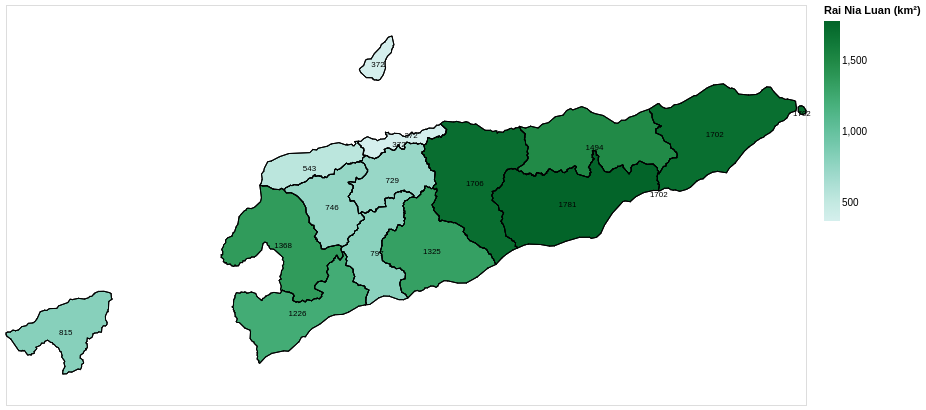

In [29]:
def generate_base(geojson, color_column, legend_title):
    
    '''Generates baselayer of DC ANC map'''
    data = altair.Data(values=geojson)
    choropleth = altair.Chart(data).mark_geoshape(
        fill='lightgray',
        stroke='black',
        strokeWidth=1
    ).encode(
        altair.Color(color_column,  # change the color based on this column's values
        type='quantitative', 
        scale=altair.Scale(scheme='bluegreen'),
        title=legend_title)
    )
    
    base = altair.Chart(altair.Data(values=geojson)).mark_geoshape(
        stroke='bluegrey',
        strokeWidth=1
    ).encode(
    ).properties(
        width=800,
        height=400
    )
    
     # Add Labels Layer
    labels = altair.Chart(choro_data).mark_text(baseline='top'
     ).properties(
        width=400,
        height=400
     ).encode(
         longitude='properties.centroid_lon:Q',
         latitude='properties.centroid_lat:Q',
         text='properties.AREA_LUAN:O',
         size=altair.value(8),
         opacity=altair.value(1)
     )
    return choropleth + base + labels

base_layer = generate_base(geojson=geojson, color_column='properties.AREA_LUAN', legend_title="Rai Nia Luan (km²)")
base_layer 